In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [54]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [55]:
# find gpu
cuda = torch.cuda.is_available()

In [56]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [57]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [84]:
# hyperparameters
NUM_LEVELS = 16
tau = 1.

In [85]:
class Encoder(nn.Module):
    def __init__(self, num_levels = NUM_LEVELS):
        super(Encoder, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(256, 64)
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 64)
        
        self.tunnels = nn.ModuleList([nn.Linear(64,64) for _ in range(num_levels-1)])
        self.codings = nn.ModuleList([nn.Linear(64,1) for _ in range(num_levels)])     
#         self.codings = nn.ModuleList([nn.Linear(64,2**(num_levels-1-_)) for _ in range(num_levels)])     
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features
    
    def forward(self, x):
#         x= x.view(-1,1,28,28)
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         # If the size is a square you can only specify a single number
#         x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = x.view(-1, self.num_flat_features(x))
#         sofar = self.relu(self.fc1(x))
        
        h1 = self.relu(self.fc1(x))
        sofar = self.relu(self.fc2(h1))
        posteriors = [self.codings[0](sofar)]
        for _ in range(len(self.tunnels)):
            sofar = self.relu(self.tunnels[_](sofar))
            posteriors.append(self.codings[_+1](sofar))
        posteriors.reverse()
        return posteriors
    
class Decoder(nn.Module):
    def __init__(self, num_levels=NUM_LEVELS):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(num_levels, 64)
        self.fc2 = nn.Linear(64,256)
        self.fc3 = nn.Linear(256,784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, code):
        h = self.relu(self.fc1(code))
        h = self.relu(self.fc2(h))
        y = self.sigmoid(self.fc3(h))
        return y

# generative model network
# used for generating cond latent distributions in training
class Hierarchy(nn.Module):
    def __init__(self, num_levels=NUM_LEVELS):
        super(Hierarchy, self).__init__()
        self.root_dist = nn.Parameter(torch.Tensor([0.0]))
        self.downwards = nn.ModuleList([nn.Linear(1,1) for _ in range(num_levels-1)])
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, codes):
        # cast to batch size dimension
#         root_dist = torch.Tensor([0.5])
#         if cuda:
#             root_dist = root_dist.cuda()
#         root_dist = Variable(root_dist, requires_grad=False).repeat(codes[0].size()[0],1)
#         cond_priors = [root_dist]
        cond_priors = [F.sigmoid(self.root_dist).repeat(codes[0].size()[0],1)]
        for _ in range(len(codes)-1):
            cond_priors.append(self.sigmoid(self.downwards[_](codes[_])))
        
        return cond_priors


In [86]:
def sample_binary_concrete(inputs, temperature = tau):
    U = Variable(torch.rand(inputs.shape), requires_grad=False)
    return F.sigmoid((U.log() - (1-U).log() + inputs)/temperature)
        
def hard_sample_binary_concrete(inputs):
    y = sample_binary_concrete(inputs)
    y_hard = torch.round(y)
    return (y_hard - y).detach() + y

In [87]:
E = Encoder()
D = Decoder()
H = Hierarchy()
if cuda:
    E.cuda()
    D.cuda()
    H.cuda()

In [88]:
optimizer = optim.Adam([
                {'params':E.parameters()},
                {'params': D.parameters()},
                {'params': H.parameters()}
            ], lr=1e-3)

In [89]:
def train(epoch):
    train_loss = 0
    kld_loss = 0
    rec_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        data = Variable(data, requires_grad=False)
        x = data.view(-1,784)
        posteriors = E(x)
        codes = [hard_sample_binary_concrete(posterior) for posterior in posteriors]
        cond_priors = H(codes)
        codes = torch.cat(codes, dim=-1)
        y = D(codes)
        kld = KLD(cond_priors, posteriors)
        rec = recon_loss(y, x)
        loss = kld + rec
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
        kld_loss += kld.data[0]
        rec_loss += rec.data[0]
#         plt.imshow(y[0].view(28,28).data.cpu().numpy())
#         plt.show()
        
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tKLD: {:.6f}\trecon_loss:{:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                batch_idx*100/ len(train_loader),
                loss.data[0], kld.data[0], rec.data[0]))
    print('====> Epoch: {} Average loss: {:.4f}\tKLD: {:.6f}\trecon_loss:{:.6f}'.format(
          epoch+1, train_loss / len(train_loader), kld_loss/ len(train_loader), rec_loss/ len(train_loader)))
    
    

In [90]:
def KLD(cond_priors, posteriors):
    cond_priors = torch.cat(cond_priors, dim = -1)
    posteriors = torch.cat(posteriors, dim = -1) 
    posteriors = F.sigmoid(posteriors)
    const = 1E-20
    kld_per_latent = posteriors * ((posteriors+const).log() - (cond_priors+const).log()) + \
                    (1-posteriors) * ((1-posteriors+const).log() - (1-cond_priors+const).log())
#     kld_per_latent = posteriors * ((posteriors+const).log() - np.log(0.5)) + \
#                      (1-posteriors) * ((1-posteriors+const).log() - np.log(0.5))
                                      
    return kld_per_latent.sum(dim=-1).mean()
    

def recon_loss(y, true_y):
    return F.binary_cross_entropy(y, true_y, size_average=False)/y.size()[0]

In [91]:
# training
epochs = 10
for epoch in range(epochs):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.065002	KLD: 0.980212	recon_loss:544.084778
Train Epoch: 1 [10000/60000 (17%)]	Loss: 200.037811	KLD: 2.394037	recon_loss:197.643768
Train Epoch: 1 [20000/60000 (33%)]	Loss: 203.136597	KLD: 2.528333	recon_loss:200.608261
Train Epoch: 1 [30000/60000 (50%)]	Loss: 191.429199	KLD: 2.612660	recon_loss:188.816544
Train Epoch: 1 [40000/60000 (67%)]	Loss: 185.087021	KLD: 3.418766	recon_loss:181.668259
Train Epoch: 1 [50000/60000 (83%)]	Loss: 183.100632	KLD: 3.918766	recon_loss:179.181870
====> Epoch: 1 Average loss: 193.2036	KLD: 3.113525	recon_loss:190.090042
Train Epoch: 2 [0/60000 (0%)]	Loss: 166.725174	KLD: 4.035843	recon_loss:162.689331
Train Epoch: 2 [10000/60000 (17%)]	Loss: 166.462814	KLD: 4.563777	recon_loss:161.899033
Train Epoch: 2 [20000/60000 (33%)]	Loss: 172.766113	KLD: 4.247860	recon_loss:168.518250
Train Epoch: 2 [30000/60000 (50%)]	Loss: 173.272339	KLD: 4.563703	recon_loss:168.708633
Train Epoch: 2 [40000/60000 (67%)]	Loss: 158.598495	KLD:

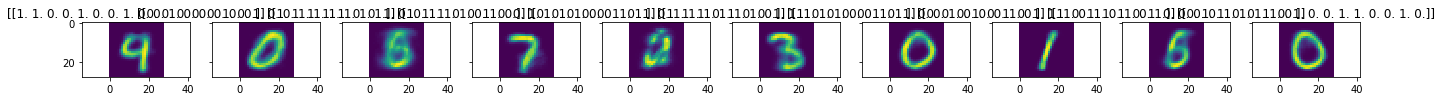

In [92]:
f, axes = plt.subplots(1, 10, sharey=True, figsize=(10,1))
plt.subplots_adjust(left=None, bottom=None, right=1.9, top=None,
                wspace=None, hspace=None)
for i in range(10):
    l = [hard_sample_binary_concrete(H.root_dist.unsqueeze(0))]
    for d in H.downwards:
        l.append(hard_sample_binary_concrete(d(l[-1])))
    l = torch.cat(l, dim=-1)
    recovery = D(l).view(28,28).data.cpu().numpy()
    ax = axes[i]
    ax.set_title(l.cpu().data.numpy())
    ax.imshow(recovery)
    i += 1
plt.show()

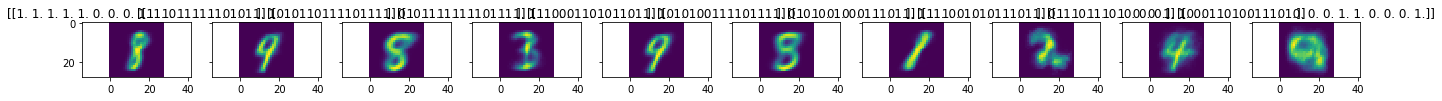

In [93]:
f, axes = plt.subplots(1, 10, sharey=True, figsize=(10,1))
plt.subplots_adjust(left=None, bottom=None, right=1.9, top=None,
                wspace=None, hspace=None)
for i in range(10):
    l = [hard_sample_binary_concrete(H.root_dist.unsqueeze(0))]
    for d in H.downwards:
        l.append(hard_sample_binary_concrete(d(l[-1])))
    l = torch.cat(l, dim=-1)
    recovery = D(l).view(28,28).data.cpu().numpy()
    ax = axes[i]
    ax.set_title(l.cpu().data.numpy())
    ax.imshow(recovery)
    i += 1
plt.show()

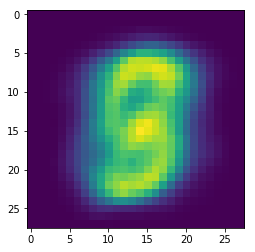

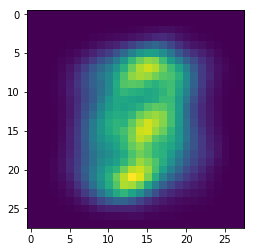

In [121]:
blah = {}
for k in range(500):
    fixed = hard_sample_binary_concrete(H.root_dist.unsqueeze(0))
    idx = int(fixed.cpu().data.numpy()[0][0])
    for i in range(10):
        h = fixed
        l = [h]
        for d in H.downwards:
            l.append(hard_sample_binary_concrete(d(l[-1])))
        l = torch.cat(l, dim=-1)
        recovery = D(l).view(28,28).data.cpu().numpy()
        blah[idx] = blah.get(idx, [])
        blah[idx].append(recovery)
plt.imshow(np.mean(np.array(blah[0]), 0))
plt.show()
plt.imshow(np.mean(np.array(blah[1]), 0))
plt.show()

Variable containing:
 1
[torch.FloatTensor of size 1x1]



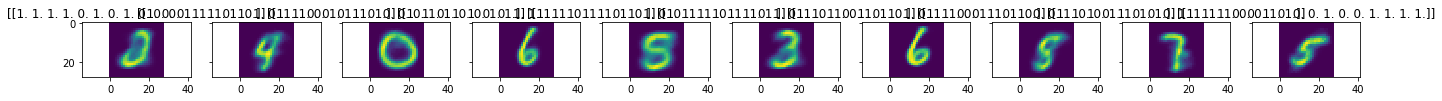

Variable containing:
 1
[torch.FloatTensor of size 1x1]



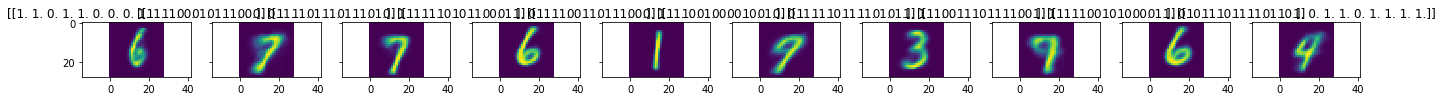

Variable containing:
 0
[torch.FloatTensor of size 1x1]



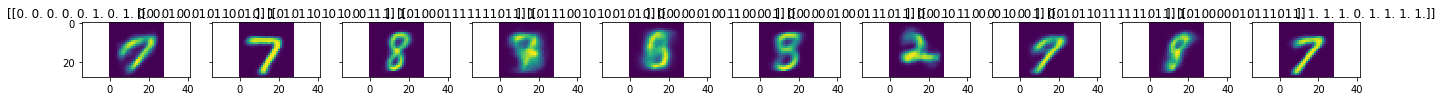

Variable containing:
 0
[torch.FloatTensor of size 1x1]



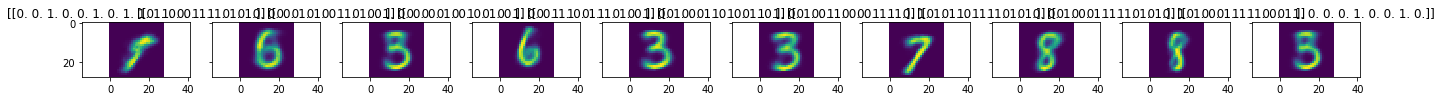

Variable containing:
 0
[torch.FloatTensor of size 1x1]



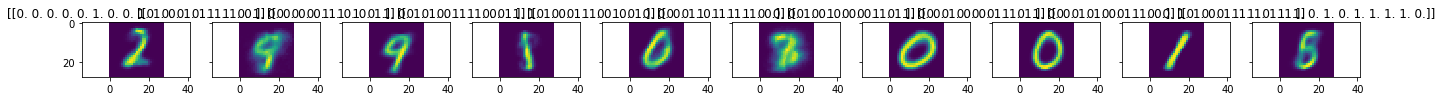

Variable containing:
 1
[torch.FloatTensor of size 1x1]



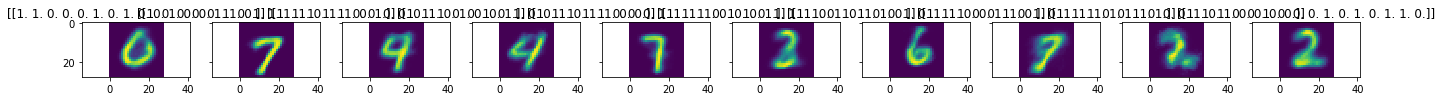

Variable containing:
 1
[torch.FloatTensor of size 1x1]



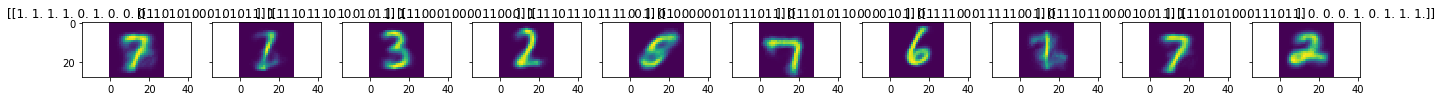

Variable containing:
 0
[torch.FloatTensor of size 1x1]



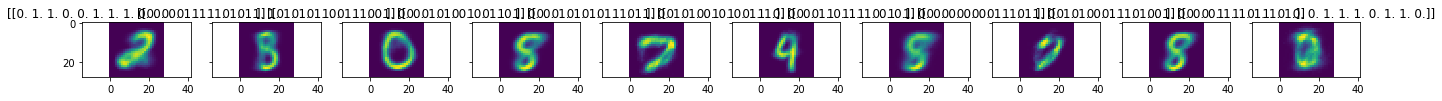

Variable containing:
 0
[torch.FloatTensor of size 1x1]



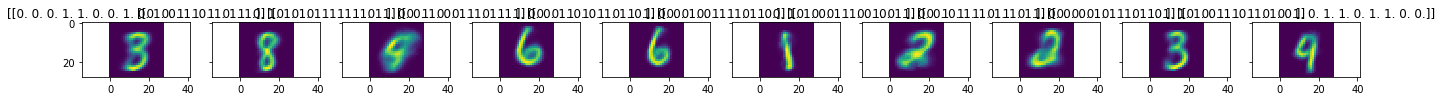

Variable containing:
 1
[torch.FloatTensor of size 1x1]



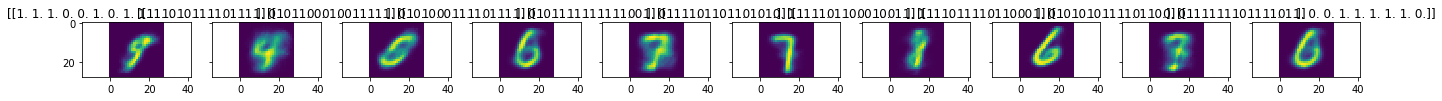

In [94]:
for k in range(10):
    f, axes = plt.subplots(1, 10, sharey=True, figsize=(10,1))
    plt.subplots_adjust(left=None, bottom=None, right=1.9, top=None,
                    wspace=None, hspace=None)
    fixed = hard_sample_binary_concrete(H.root_dist.unsqueeze(0))
    print(fixed)
    for i in range(10):
        h = fixed
        l = [h]
        for d in H.downwards:
            l.append(hard_sample_binary_concrete(d(l[-1])))
        l = torch.cat(l, dim=-1)
        recovery = D(l).view(28,28).data.cpu().numpy()
        ax = axes[i]
        ax.set_title(l.cpu().data.numpy())
        ax.imshow(recovery)
    plt.show()

In [42]:
H.downwards

ModuleList(
  (0): Linear(in_features=1, out_features=2)
  (1): Linear(in_features=2, out_features=4)
)

In [45]:
a

[Variable containing:
  0
 [torch.FloatTensor of size 1x1], Variable containing:
  1  0
 [torch.FloatTensor of size 1x2], Variable containing:
  1  0  1  1
 [torch.FloatTensor of size 1x4]]

[Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
]


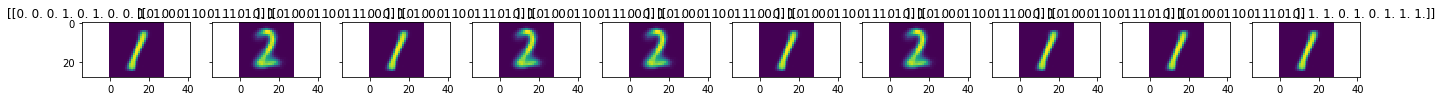

[Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
]


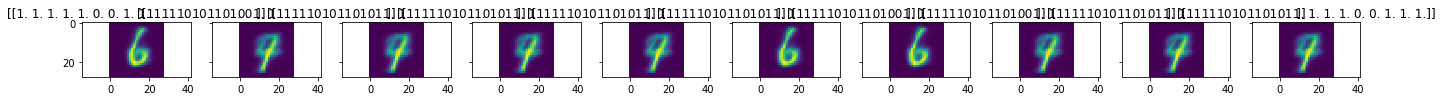

[Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
]


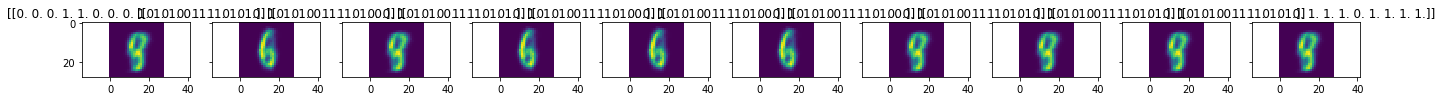

[Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
]


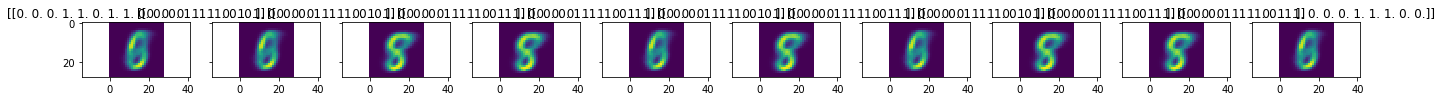

[Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
]


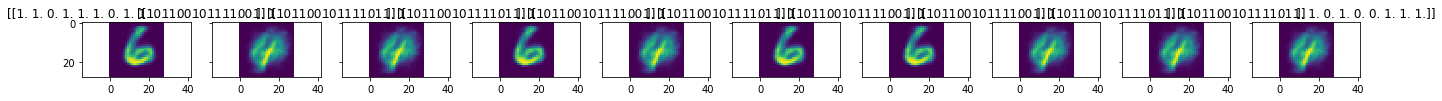

[Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
]


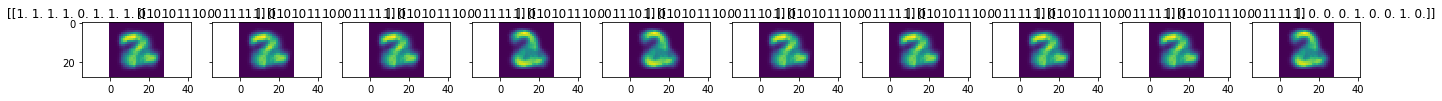

[Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
]


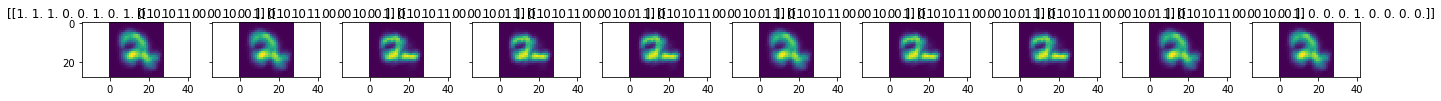

[Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
]


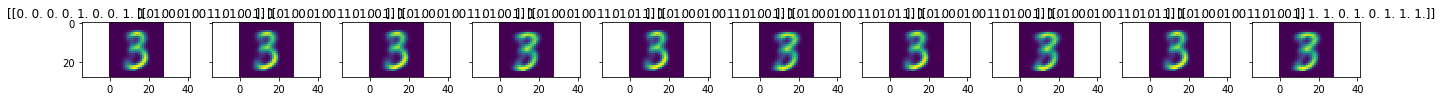

[Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
]


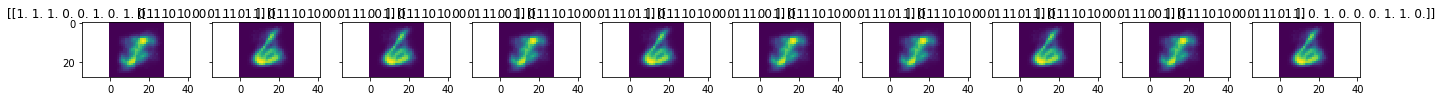

[Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 0
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
, Variable containing:
 1
[torch.FloatTensor of size 1x1]
]


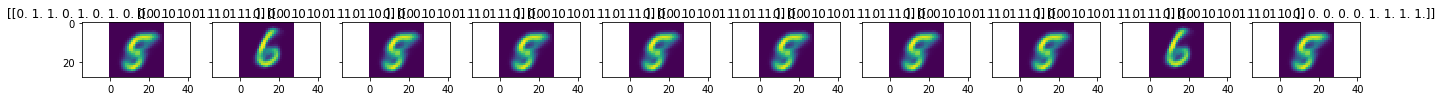

In [95]:
for k in range(10):
    f, axes = plt.subplots(1, 10, sharey=True, figsize=(10,1))
    plt.subplots_adjust(left=None, bottom=None, right=1.9, top=None,
                    wspace=None, hspace=None)
    a= [hard_sample_binary_concrete(H.root_dist.unsqueeze(0))]
    for d in list(H.downwards)[:14]:
        a.append(hard_sample_binary_concrete(d(a[-1])))
    print(a)
    for i in range(10):
        l=a.copy()
        for d in list(H.downwards)[14:]:
            l.append(hard_sample_binary_concrete(d(l[-1])))
        l = torch.cat(l, dim=-1)
        recovery = D(l).view(28,28).data.cpu().numpy()
        ax = axes[i]
        ax.set_title(l.cpu().data.numpy())
        ax.imshow(recovery)
        i += 1
    plt.show()

Variable containing:
 1
[torch.FloatTensor of size 1x1]



RuntimeError: size mismatch, m1: [1 x 4], m2: [7 x 64] at /opt/conda/conda-bld/pytorch-cpu_1515613813020/work/torch/lib/TH/generic/THTensorMath.c:1416

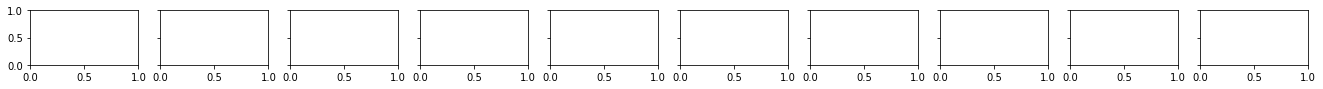

In [36]:
for k in range(10):
    f, axes = plt.subplots(1, 10, sharey=True, figsize=(10,1))
    plt.subplots_adjust(left=None, bottom=None, right=1.9, top=None,
                    wspace=None, hspace=None)
    fixed = hard_sample_binary_concrete(H.root_dist.unsqueeze(0))
    print(fixed)
    for d in list(H.downwards)[:2]:
        fixed = hard_sample_binary_concrete(d(fixed))
    for i in range(10):
        h = fixed
        for d in list(H.downwards)[2:]:
            h = hard_sample_binary_concrete(d(h))
        recovery = D(h).view(28,28).data.cpu().numpy()
        ax = axes[i]
        ax.set_title(h.cpu().data.numpy())
        ax.imshow(recovery)
        i += 1
    plt.show()

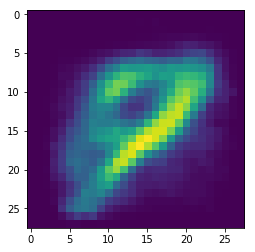

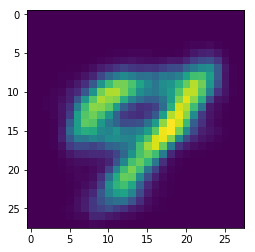

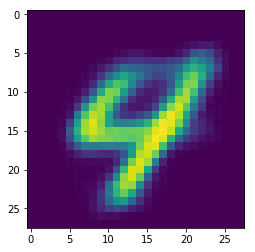

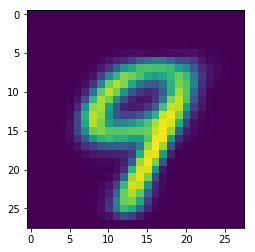

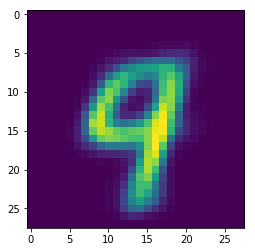

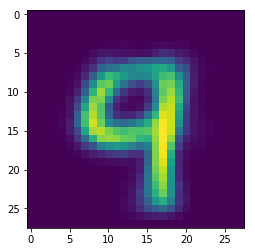

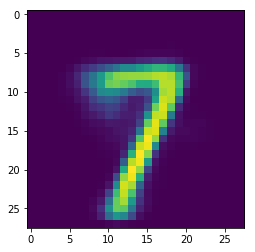

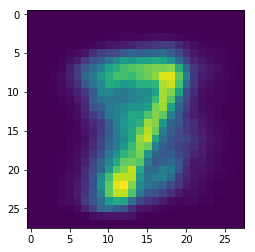

In [130]:
a = torch.FloatTensor((0,0,0,0,0,0,0,0))
for i in range(8):
#     a = torch.FloatTensor((0,0,0,0,0,0,0,0))
    a[i] = 1.
    t = Variable(a).unsqueeze(0)
    recovery = D(t).view(28,28).data.cpu().numpy()
    plt.imshow(recovery)
    plt.show()

In [35]:
F.sigmoid(H.downwards[0](Variable(torch.Tensor([0.])).unsqueeze(0)))

Variable containing:
 0.5315  0.4490
[torch.FloatTensor of size 1x2]

In [34]:
print(F.sigmoid(H.downwards[1](Variable(torch.Tensor([0., 0.]))).unsqueeze(0)))
print(F.sigmoid(H.downwards[1](Variable(torch.Tensor([1., 0.]))).unsqueeze(0)))
print(F.sigmoid(H.downwards[1](Variable(torch.Tensor([1., 1.]))).unsqueeze(0)))
print(F.sigmoid(H.downwards[1](Variable(torch.Tensor([0., 1.]))).unsqueeze(0)))

Variable containing:
 0.5614  0.7869  0.6230  0.6805
[torch.FloatTensor of size 1x4]

Variable containing:
 0.6831  0.7405  0.5852  0.8598
[torch.FloatTensor of size 1x4]

Variable containing:
 0.6149  0.5116  0.5666  0.8797
[torch.FloatTensor of size 1x4]

Variable containing:
 0.4866  0.5755  0.6050  0.7174
[torch.FloatTensor of size 1x4]

